In [3]:
import os
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from pycbc import psd as psd_func
from pycbc.filter import sigma, match
from pesummary.gw.conversions.mass import component_masses_from_mchirp_q, q_from_eta
from simple_pe.waveforms import generate_eccentric_waveform, calculate_eccentric_harmonics, calc_f_gen, shifted_f, shifted_e
from simple_pe.param_est import find_metric_and_eigendirections
from calcwf import match_hn
from interpolating_match import comb_harm_consistent

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Is MA measurement consistent across harmonics with different parameters?

In [17]:
M = 60
q = 2
e = 0.2
f = 10

h, _ = generate_eccentric_waveform(M, q, e, 0, 0, f, 4096, tlen=32, to_fs=False)
harms = calculate_eccentric_harmonics(M, q, e, 0, 0, f, 4096, tlen=32, n_ecc_harms=2)
wf_hjs = [harms[key].to_timeseries() for key in [0,1]]
matches = match_hn(wf_hjs, h, 10, f_match=20)
true_MA = (np.angle(matches[1])-np.angle(matches[0]))%(2*np.pi)
print(f'True MA: {true_MA:.2f}')

MAs = []
for i in range(10):
    harm_M = np.random.uniform(59,61)
    harm_q = np.random.uniform(1.9,2.1)
    harm_e = np.random.uniform(0.19,0.21)
    harm_chi1 = np.random.uniform(0.05,-0.05)
    harm_chi2 = np.random.uniform(0.05,-0.05)
    harms = calculate_eccentric_harmonics(harm_M, harm_q, harm_e, harm_chi1, harm_chi2, f, 4096, tlen=32, n_ecc_harms=2)
    wf_hjs = [harms[key].to_timeseries() for key in [0,1]]
    matches = match_hn(wf_hjs, h, 10, f_match=20)
    print(f'0: M = {np.abs(matches[0]):.2f} with angle of {np.angle(matches[0])%(2*np.pi):.2f}')
    print(f'1: M = {np.abs(matches[1]):.2f} with angle of {np.angle(matches[1])%(2*np.pi):.2f}')
    MAs.append((np.angle(matches[1])-np.angle(matches[0]))%(2*np.pi))
    print(f'MA measurement: {MAs[-1]:.2f}')

True MA: 0.70
0: M = 0.97 with angle of 3.35
1: M = 0.20 with angle of 3.51
MA measurement: 0.16
0: M = 0.96 with angle of 5.73
1: M = 0.20 with angle of 3.81
MA measurement: 4.37
0: M = 0.93 with angle of 6.02
1: M = 0.13 with angle of 0.30
MA measurement: 0.56
0: M = 0.94 with angle of 1.76
1: M = 0.16 with angle of 1.71
MA measurement: 6.23
0: M = 0.96 with angle of 1.79
1: M = 0.20 with angle of 2.43
MA measurement: 0.64
0: M = 0.97 with angle of 3.03
1: M = 0.21 with angle of 3.44
MA measurement: 0.40
0: M = 0.97 with angle of 1.18
1: M = 0.22 with angle of 5.18
MA measurement: 4.01
0: M = 0.95 with angle of 4.11
1: M = 0.21 with angle of 2.96
MA measurement: 5.14
0: M = 0.96 with angle of 5.83
1: M = 0.18 with angle of 3.48
MA measurement: 3.94
0: M = 0.96 with angle of 2.38
1: M = 0.15 with angle of 0.68
MA measurement: 4.58


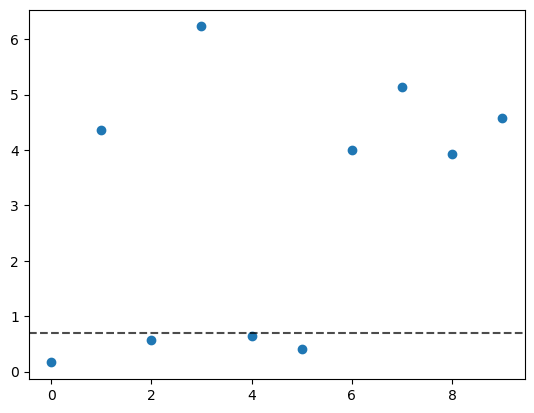

In [18]:
plt.scatter(np.arange(len(MAs)), MAs)
plt.axhline(true_MA, c='k', ls='dashed', alpha=0.7)

The MA measurement is therefore not consistent across harmonics built at different points in parameter space - suspect it is likely linked/normalised relative to MA of e.g. s_0 when building harmonics.

# Finding peak ecc/MA

In [4]:
with open(os.path.join('grid_data_4d', 'dataslot_8', 'all_matches'), 'rb') as fp:
    all_matches = pickle.load(fp)
with open(os.path.join('grid_data_4d', 'dataslot_8', 'param_samples'), 'rb') as fp:
    param_samples = pickle.load(fp)

The peak point on the degeneracy line we should find in using a 'linear' parameter, i.e. e^2, chirp mass etc, and find peak density using a gaussian kde.

To find peak MA we will use the same approach.

To draw the samples on MA that we need (and will combine with samples drawn from new metric), we will use inverse transform sampling from the kde we built to find the peak.

In [5]:
def get_peak_e_MA(all_matches, param_samples, n_MA=0):

    # Build kde and find peak for e
    e2_kernel = gaussian_kde(param_samples['samples']['ecc10']**2)
    e2_arr = np.linspace(0, np.max(param_samples['samples']['ecc10'])**2, 10**3)
    e2_kde_dens = e2_kernel(e2_arr)
    e2_peak = e2_arr[np.argmax(e2_kde_dens)]

    # Build kde and find peak for MA
    MA_kde_builders = np.concatenate([param_samples['samples']['MA'], param_samples['samples']['MA']+2*np.pi, param_samples['samples']['MA']-2*np.pi])
    MA_kernel = gaussian_kde(MA_kde_builders, bw_method=0.01)
    MA_arr = np.linspace(0,2*np.pi,10**3,endpoint=False)
    MA_kde_dens = MA_kernel(MA_arr)
    MA_peak = MA_arr[np.argmax(MA_kde_dens)]

    # Build peak dictionary
    base_dict = all_matches['metadata']['base_params']
    fid_dict = all_matches['metadata']['fid_params']
    degen_dist = (e2_peak-base_dict['ecc10sqrd'])/(fid_dict['ecc10sqrd']-base_dict['ecc10sqrd'])
    peak_dict = {'MA': MA_peak}
    for key in list(all_matches['metadata']['fid_params'].keys()):
        peak_dict[key] = degen_dist*(fid_dict[key]-base_dict[key])+base_dict[key]

    # Draw more samples on MA using inverse transform sampling from kde
    if n_MA > 0:
        MA_draw = np.concatenate([[0], MA_arr[1:], [2*np.pi]])
        MA_cumsum = np.cumsum(MA_kde_dens)
        MA_cdf_2pi = MA_cumsum[-1]+MA_kde_dens[0]
        MA_cdf = np.concatenate([[0], MA_cumsum[1:]/MA_cdf_2pi, [1]])
        MA_uni_samples = np.random.rand(n_MA)
        MA_draw_interp = interp1d(MA_cdf, MA_draw)
        MA_samples = MA_draw_interp(MA_uni_samples)
        return peak_dict, MA_samples
    else:
        return peak_dict

In [6]:
peak_dict, MA_samples = get_peak_e_MA(all_matches, param_samples, n_MA=10**6)
print(peak_dict)

{'MA': 0.6848671984825749, 'ecc10sqrd': 0.0317897548807485, 'chirp_mass': 24.28587947335138, 'symmetric_mass_ratio': 0.20306357014978405, 'chi_eff': 0.11955229707475908}


(0.0, 6.283185307179586)

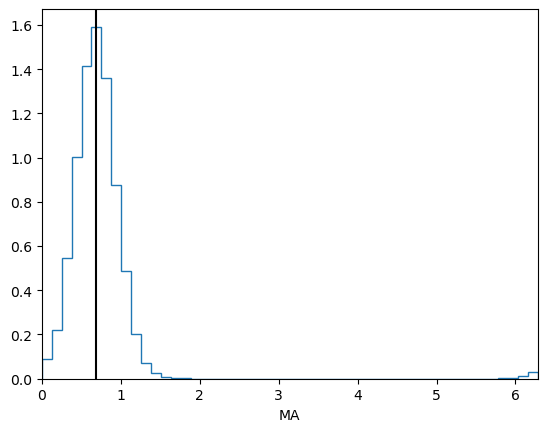

In [7]:
_ = plt.hist(param_samples['samples']['MA'], bins=50, range=(0,2*np.pi), density=True, histtype='step')
plt.axvline(peak_dict['MA'], c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)

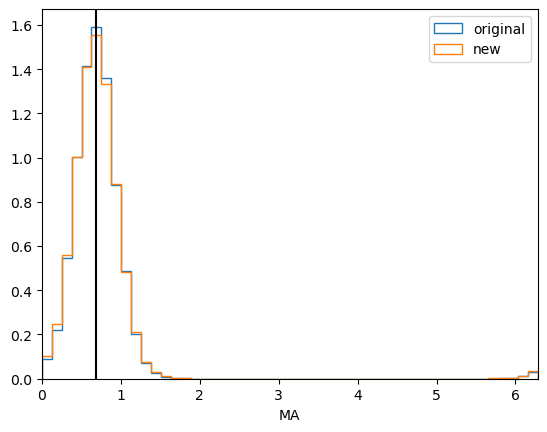

In [8]:
_ = plt.hist(param_samples['samples']['MA'], bins=50, range=(0,2*np.pi), density=True, histtype='step', label='original')
_ = plt.hist(MA_samples, bins=50, range=(0,2*np.pi), density=True, histtype='step', label='new')
plt.axvline(peak_dict['MA'], c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)
plt.legend()

# Calculating metric at peak and drawing samples

Here we will calculate the metric at the new peak values (mean anomaly is not important here as we will use the h0 harmonic for metric calculation).

We can then draw samples from the metric, and add the MA distribution calculated in the previous step.

First off however we need to 'recalibrate' the mean anomaly to the new set of harmonics. We can also generate the harmonics at the peak parameters here and use it for future steps.

In [9]:
def recal_MA(all_matches, peak_dict, n_ecc_harms, n_ecc_gen, f_low, psd, sample_rate, two_ecc_harms=True, MA_samples=None):

    # Calculate harmonic ordering
    harm_ids = [0,1]
    for i in range(2,n_ecc_harms):
        if harm_ids[-1] > 0:
            harm_ids.append(-harm_ids[-1])
        else:
            harm_ids.append(-harm_ids[-1]+1)

    # Generate harmonics at peak
    peak_dict['mass_ratio'] = q_from_eta(peak_dict['symmetric_mass_ratio'])
    peak_dict['inverted_mass_ratio'] = 1/peak_dict['mass_ratio']
    peak_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(peak_dict['chirp_mass'], peak_dict['mass_ratio']), axis=0)
    tlen = int(1/psd.delta_f)
    wf_dict = calculate_eccentric_harmonics(peak_dict['total_mass'], peak_dict['inverted_mass_ratio'], peak_dict['ecc10sqrd']**0.5, peak_dict['chi_eff'],
                                            peak_dict['chi_eff'], f_low, sample_rate, tlen=tlen, f_ref_e=10, n_ecc_harms=n_ecc_harms, n_ecc_gen=n_ecc_gen)
    wf_hjs = [wf_dict[ind].to_timeseries() for ind in harm_ids]

    # Test three MA values from gridded matches
    dist_to_peak = np.abs(all_matches['metadata']['degen_params']['ecc10sqrd']-peak_dict['ecc10sqrd'])
    idx = np.argpartition(dist_to_peak, 3)[:3]
    f_gen = calc_f_gen(f_low, n_ecc_harms)
    MA_diff_cplx = 0j
    for pos in idx:
        params = {key: all_matches['metadata']['degen_params'][key][pos] for key in all_matches['metadata']['degen_params'].keys()}
        h = generate_eccentric_waveform(params['total_mass'], params['inverted_mass_ratio'], params['ecc10'], params['chi_eff'],
                                        params['chi_eff'], f_gen, sample_rate, f_ref_e=10, tlen=tlen, to_fs=False)[0]
        match_cplx = match_hn(wf_hjs, h, f_gen, psd=psd, f_match=f_low)
        if two_ecc_harms:
            MA_old = all_matches['h1_h-1_h0_pc_phase'][pos][0]
            _, MA_new = comb_harm_consistent(np.abs(match_cplx[:3]), np.angle(match_cplx[:3]), harms=[0,1,-1])
        else:
            MA_old = (all_matches['h1_phase'][pos][0]-all_matches['h0_phase'][pos][0])%(2*np.pi)
            MA_new = (np.angle(match_cplx[1])-np.angle(match_cplx[0]))%(2*np.pi)
        MA_diff_cplx += np.exp(1j*(MA_new - MA_old))
    MA_diff = np.angle(MA_diff_cplx)

    # Return calibrated peak MA and MA samples
    peak_dict['recal_MA'] = (peak_dict['MA']+MA_diff)%(2*np.pi)
    if MA_samples is None:
        return peak_dict, wf_hjs
    else:
        recal_MA_samples = (MA_samples+MA_diff)%(2*np.pi)
        return peak_dict, recal_MA_samples, wf_hjs

In [10]:
# Create psd
f_low = 20
sample_rate = 4096
tlen = 32
ifos = ['H1']
psds = {'H1': 'aLIGOZeroDetHighPower',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }
psd = {}
for ifo in ifos:
    psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                     psds['f_low'])

(0.0, 6.283185307179586)

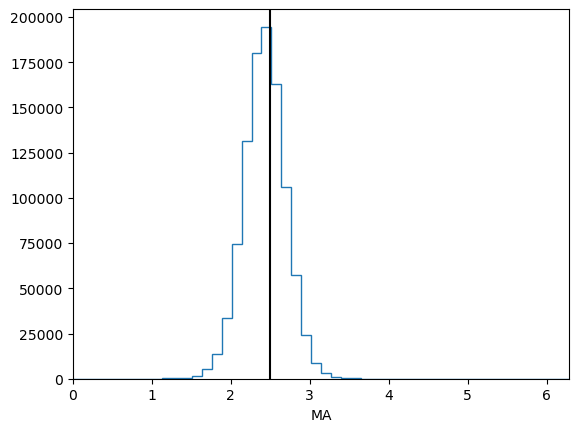

In [11]:
# Recalibrate to 'new' MA normalisation
peak_dict, recal_MA_samples, wf_hjs = recal_MA(all_matches, peak_dict, 4, 6, f_low, psd['H1'], sample_rate, MA_samples=MA_samples, two_ecc_harms=True)

# Generate true waveform with same parameters as used to generate this analysis to compare to 'true' MA
target_snr = 20
true_dict = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
true_dict['mass_ratio'] = q_from_eta(true_dict['symmetric_mass_ratio'])
true_dict['inverted_mass_ratio'] = 1/true_dict['mass_ratio']
true_dict['total_mass'] = np.sum(component_masses_from_mchirp_q(true_dict['chirp_mass'], true_dict['mass_ratio']), axis=0)
data, _ = generate_eccentric_waveform(true_dict['total_mass'], true_dict['inverted_mass_ratio'], true_dict['ecc10sqrd']**0.5,
                                      true_dict['chi_eff'], true_dict['chi_eff'], 10, sample_rate, f_ref_e=10, tlen=tlen, to_fs=False)
raw_snr = sigma(data, psd['H1'], low_frequency_cutoff=f_low, high_frequency_cutoff=psds['f_high'])
data = data*target_snr/raw_snr
f_gen = calc_f_gen(f_low, 4)
match_cplx = match_hn(wf_hjs, data, f_gen, psd=psd['H1'], f_match=f_low)
true_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0]))%(2*np.pi)

# Plot true MA on recalibrated MA samples to ensure they match
_ = plt.hist(recal_MA_samples, bins=50, range=(0,2*np.pi), histtype='step')
plt.axvline(true_MA, c='k')
plt.xlabel('MA')
plt.xlim(0,2*np.pi)

The recalibration seems to be working well.

In order to calculate the snr for the new metric to be calculated, we must generate a waveform at the peak values and with the peak MA. We therefore want a wrapper function that generates a waveform at a given MA value - this will also be useful later for the 5x5x5... grid interpolant.

In [12]:
def ecc_wf_with_MA(wf_hjs, target_MA, param_dict, f_low, psd, tol=0.03, max_iter=10, use_s_factor=True, two_ecc_harms=True):

    # Get psd parameters
    df = psd.delta_f
    flen = len(psd)

    # Initialise iteration
    current_tol = 2*np.pi
    best_tol = 2*np.pi
    current_iter = 0
    MA = 0
    s_factor = 1
    while current_tol > tol and current_iter <= max_iter:

        # Shift to f, e for required MA
        s_f_2pi =  (10 - shifted_f(10, param_dict['ecc10sqrd']**0.5, param_dict['total_mass'], param_dict['inverted_mass_ratio']))*s_factor
        s_f = 10 - s_f_2pi*MA/(2*np.pi)
        s_e = shifted_e(s_f, 10, param_dict['ecc10sqrd']**0.5)

        # Generate and match wf at requested MA
        s_rate = 2 * int(flen*df)
        tlen = int(1/df)
        hp, hc = generate_eccentric_waveform(param_dict['total_mass'], param_dict['inverted_mass_ratio'], s_e,
                                             param_dict['chi_eff'], param_dict['chi_eff'], s_f, s_rate, tlen=tlen, to_fs=False)
        h = hp - 1j*hc
        match_cplx = match_hn(wf_hjs, h, f_low, psd=psd, f_match=f_low)
        if two_ecc_harms:
            _, meas_MA = comb_harm_consistent(np.abs(match_cplx[:3]), np.angle(match_cplx[:3]), harms=[0,1,-1])
        else:
            meas_MA = (np.angle(match_cplx[1])-np.angle(match_cplx[0]))%(2*np.pi)
        

        # Calculate s_factor after first wf generation
        if current_iter == 0 and use_s_factor:
            s_f_max = shifted_f(10, param_dict['ecc10sqrd']**0.5, param_dict['total_mass'], param_dict['inverted_mass_ratio'])
            s_e_max = shifted_e(s_f_max, 10, param_dict['ecc10sqrd']**0.5)
            s_hp, s_hc = generate_eccentric_waveform(param_dict['total_mass'], param_dict['inverted_mass_ratio'], s_e_max,
                                                     param_dict['chi_eff'], param_dict['chi_eff'], s_f_max, s_rate, tlen=tlen, to_fs=False)
            s_h = s_hp - 1j*s_hc
            h_peaks_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
            s_peaks_inds = np.diff(np.sign(np.diff(np.abs(s_h)))) < 0
            h_peaks = h.sample_times[1:-1][h_peaks_inds]
            s_peaks = s_h.sample_times[1:-1][s_peaks_inds]
            if len(h_peaks) >= 2 and len(s_peaks) >= 2:
                s_factor = 1/(1+(h_peaks[0]-s_peaks[1])/(h_peaks[1]-h_peaks[0]))
            
        # Update MA, tolerance, and iteration count
        MA_diff = (target_MA-meas_MA)%(2*np.pi)
        current_tol = np.abs((MA_diff+np.pi)%(2*np.pi)-np.pi)
        if current_tol < best_tol:
            best_tol = current_tol
            best_wf = h
        MA = (MA+MA_diff)%(2*np.pi)
        current_iter += 1

    return best_wf

def get_peak_snr(data, wf_hjs, peak_dict, f_low, psd, tol=0.03, max_iter=10, two_ecc_harms=True):
    peak_wf = ecc_wf_with_MA(wf_hjs, peak_dict['recal_MA'], peak_dict, f_low, psd, tol=tol, max_iter=max_iter, two_ecc_harms=two_ecc_harms)
    snr, _ = match(data.real(), peak_wf.real(), psd, low_frequency_cutoff=f_low, v1_norm=1)
    return snr

Now with the SNR calculated using these functions we can calculate the new metric.

In [13]:
all_matches['metadata']['base_params']

{'chirp_mass': 24.675282678323956,
 'symmetric_mass_ratio': 0.2044973059848044,
 'chi_eff': 0.14208658439088648,
 'ecc10sqrd': 0,
 'f_ref': 20}

In [14]:
peak_dict

{'MA': 0.6848671984825749,
 'ecc10sqrd': 0.0317897548807485,
 'chirp_mass': 24.28587947335138,
 'symmetric_mass_ratio': 0.20306357014978405,
 'chi_eff': 0.11955229707475908,
 'mass_ratio': 0.39538484983418787,
 'inverted_mass_ratio': 2.5291813796592586,
 'total_mass': 63.208374932291974,
 'recal_MA': 2.433640311585386}

In [19]:
def peak_metric_samples(peak_dict, snr, f_low, psd, MA_samples=None):

    # Uses simple-pe to calculate approx. of posterior dist. using metric, eigendirections
    metric_dict = {'f_ref': f_low}
    par_dirs = ['chirp_mass', 'chi_eff', 'symmetric_mass_ratio', 'ecc10sqrd']
    for par in par_dirs:
        metric_dict[par] = peak_dict[par]
    par_dirs = ['chirp_mass', 'symmetric_mass_ratio', 'ecc10sqrd']
    
    # Calculate metric and find fiducial point
    metric = find_metric_and_eigendirections(metric_dict, par_dirs, snr=snr, f_low=f_low, psd=psd,
                                             approximant='TEOBResumS-Dali', max_iter=2, multiprocessing=False)

In [ ]:
snr = get_peak_snr(data, wf_hjs, peak_dict, f_low, psd['H1'], tol=0.03, max_iter=10, two_ecc_harms=True)
peak_metric_samples(peak_dict, snr, f_low, psd['H1'], MA_samples=MA_samples)

Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 


Calculating the metric | iteration 0 < 2| error 0.0078 > 0.0004

Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 
Initial frequency too high. Set f0 to 1.37e-02 
